# Aerial Object Classification (Bird vs Drone)

This project uses a deep learning model (ResNet50) to classify aerial images
as either Bird or Drone.

ResNet is a convolutional neural network with residual (skip) connections,
which helps deep networks learn better and avoid vanishing gradient problems.

In [1]:
# STEP 1: Import required libraries
# File and folder handling
import os
import zipfile
import shutil
import random
import hashlib

# Numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

# Image handling
from PIL import Image

In [3]:
# STEP 2: Extract dataset
# Unzipping train, validation, and test datasets
import zipfile
zip_path = "train-20251113T112441Z-1-001.zip"   
extract_path = "."

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Done!")

Done!


In [4]:
zip_path = "valid-20251113T112444Z-1-001.zip"     
extract_path = "."

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Done!")

Done!


In [5]:
zip_path = "test-20251113T112437Z-1-001.zip"     
extract_path = "."

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Done!")

Done!


In [6]:
# STEP 3: Dataset count check
# Checking number of images in each class

for split in ["train", "valid", "test"]:
    print(f"\n{split.upper()} DATA")
    for cls in ["bird", "drone"]:
        path = os.path.join(split, cls)
        print(cls, ":", len(os.listdir(path)))


TRAIN DATA
bird : 1414
drone : 1248

VALID DATA
bird : 217
drone : 225

TEST DATA
bird : 121
drone : 94


⚠️ Note:
If bird images are fewer than drone images, the model can become biased.
This will be handled using data augmentation and class weights.

In [7]:
# STEP 4: Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Strong augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4]
)

# No augmentation for validation & test
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [8]:
# STEP 5: Create data generators
train_generator = train_datagen.flow_from_directory(
    "train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

valid_generator = valid_datagen.flow_from_directory(
    "valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    "test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [9]:
# STEP 6: Build ResNet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pretrained ResNet50
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Enable fine-tuning
base_model.trainable = True

# Freeze early layers (low-level features)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

In [10]:
# STEP 7: Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [11]:
# STEP 8: Handle class imbalance

class_weight = {
    0: 1.5,  # bird
    1: 1.0   # drone
}

In [12]:
# STEP 9: Train model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    class_weight=class_weight
)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.6386 - loss: 0.7766 - val_accuracy: 0.5747 - val_loss: 11.5794
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7081 - loss: 0.6867 - val_accuracy: 0.6063 - val_loss: 10.4115
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7333 - loss: 0.6360 - val_accuracy: 0.6629 - val_loss: 1.7654
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7258 - loss: 0.6479 - val_accuracy: 0.7760 - val_loss: 0.8066
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7325 - loss: 0.6348 - val_accuracy: 0.6697 - val_loss: 1.2963
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7400 - loss: 0.6228 - val_accuracy: 0.7534 - val_loss: 0.5962
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7370 - loss: 0.6232 - val_accuracy: 0.7760 - val_loss: 0.6356
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7461 - loss: 0.6108 - val_accuracy: 0.8009 -

In [13]:
# STEP 10: Evaluate model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 916ms/step - accuracy: 0.5953 - loss: 0.6696
Test Accuracy: 0.5953488349914551


In [15]:
# Saving the trained model for deployment in Streamlit app
os.makedirs("models", exist_ok=True)
model.save("models/resnet_bird_drone_finetuned.keras")

## Conclusion

- ResNet50 was used to leverage residual connections for deep learning
- Data augmentation improved generalization
- Fine-tuning helped distinguish birds from drones
- Class imbalance was handled using class weights
- The trained model is saved for deployment

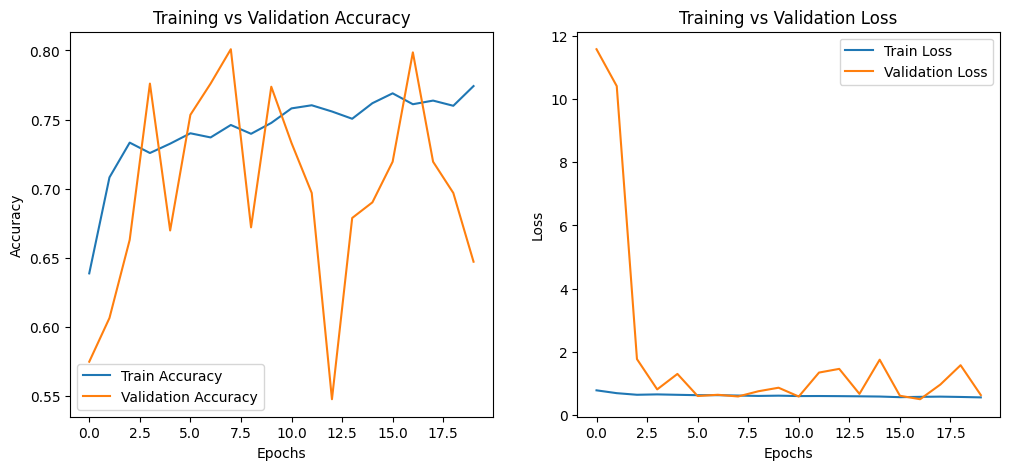

In [16]:
#Accuracy & Loss Plots
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [17]:
#Classification Report
from sklearn.metrics import classification_report

# Get true labels
true_labels = test_generator.classes

# Get predictions
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Print report
print(classification_report(
    true_labels,
    pred_labels,
    target_names=["Bird", "Drone"]
))

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
              precision    recall  f1-score   support

        Bird       0.89      0.32      0.47       121
       Drone       0.52      0.95      0.67        94

    accuracy                           0.60       215
   macro avg       0.70      0.63      0.57       215
weighted avg       0.73      0.60      0.56       215



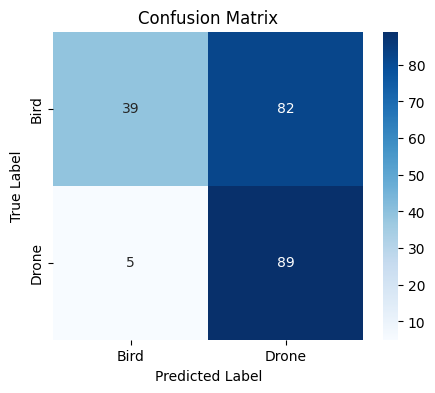

In [18]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Bird", "Drone"],
    yticklabels=["Bird", "Drone"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [19]:
#Grad-CAM Visualization
import tensorflow as tf
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

C:\Users\fathi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


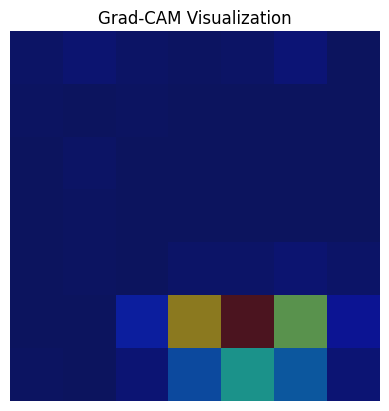

In [20]:
# Load one test image
img_path = test_generator.filepaths[0]

img = Image.open(img_path).resize((224, 224))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="conv5_block3_out"
)

# Display
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()